In [147]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, get_vertical_discretization_time, EM1DSurveyTD
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Seogi\Minconda3\envs\simpeg\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'inv', 'e', 'time', 'std', 'floor']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Seting up a 2D mesh and model

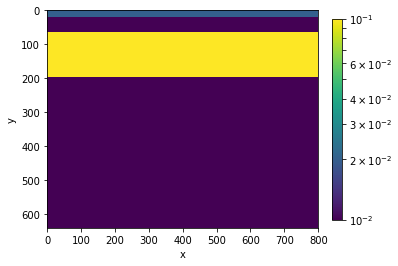

In [148]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds
from simpegEM1D import skytem_HM_2015
wave = skytem_HM_2015()
time = np.logspace(-5, -2, 21)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]
n_sounding = 40
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 200.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 0.1
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()
chi = np.zeros_like(sigma_em1d)
# chi[poly_inds] = 0.005
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)


In [149]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [150]:
mapping = Maps.ExpMap(mesh)
survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = [time for i in range(n_sounding)],
    src_type = np.array(["CircularLoop"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    wave_type = np.array(["stepoff"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    a = np.array([13.]).repeat(n_sounding),
    input_currents=[input_currents for i in range(n_sounding)],
    time_input_currents=[time_input_currents for i in range(n_sounding)],
    base_frequency = np.array([20.]).repeat(n_sounding),
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=False, n_cpu=6,
    Solver=PardisoSolver
)
prob.pair(survey)
m = np.log(sigma_em1d)
dobs = survey.makeSyntheticData(m, std=0.05, force=True)

>> Set parameters
>> Serial version is used


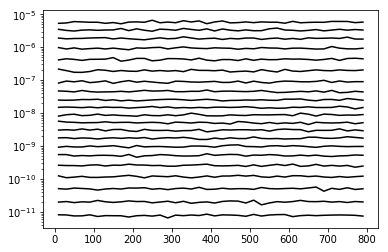

In [151]:
DOBS = dobs.reshape(( prob.n_sounding, time.size))
for i_time in range(time.size):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')

In [152]:
def get_data_time_index(dobs, n_sounding, time, time_index):
    n_time = time.size
    DOBS = dobs.reshape((n_sounding, n_time))
    return DOBS[:,time_index].flatten()
time_index = [0, 1, 2]
dobs_reduced = get_data_time_index(dobs, n_sounding, time, time_index)

In [153]:
hz = np.r_[1.]
mapping = Maps.ExpMap(nP=n_sounding)

wires = Maps.Wires(('sigma', n_sounding),('h', n_sounding))
expmap = Maps.ExpMap(nP=n_sounding)
sigmaMap = expmap * wires.sigma

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = [time[time_index] for i in range(n_sounding)],
    src_type = np.array(["CircularLoop"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    wave_type = np.array(["stepoff"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    a = np.array([13.]).repeat(n_sounding),
    input_currents=[input_currents for i in range(n_sounding)],
    time_input_currents=[time_input_currents for i in range(n_sounding)],
    base_frequency = np.array([20.]).repeat(n_sounding),
    half_switch=True
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=sigmaMap, hMap=wires.h, hz=hz, parallel=False, n_cpu=6,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Serial version is used


In [154]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)
from simpegEM1D import get_2d_mesh, LateralConstraint

In [155]:
mesh_reg = get_2d_mesh(n_sounding, np.r_[1])
# mapping is required ... for IRLS
reg_sigma = LateralConstraint(
    mesh_reg, mapping=wires.sigma,
    alpha_s=1,
    alpha_x = 1.,
    alpha_y = 1.,    
)
reg_sigma.get_grad_horizontal(topo, hz, dim=2)
regmap_height = Maps.IdentityMap(mesh_reg)
# mapping is required ... for IRLS
reg_height = LateralConstraint(
    mesh_reg, mapping=wires.h,
    alpha_s=0,
    alpha_x = 1.,
    alpha_y = 1.,    
)
reg_height.get_grad_horizontal(topo, hz, dim=2)
reg = reg_sigma + reg_height

In [163]:
%%time
std = 0.2
floor = 0.
np.random.seed(1)
uncert = std*abs(dobs_reduced)+floor
survey.dobs = dobs_reduced.copy()
e = np.ones(n_sounding)
m0 = np.r_[e*np.log(1./100.), e*50]
dmisfit = DataMisfit.l2_DataMisfit(survey)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[betaest,beta,target])
invProb.beta=0.
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.54e+01  1.34e+04  0.00e+00  1.34e+04    6.80e+02      0              
   1  1.27e+01  1.05e+04  7.01e-26  1.05e+04    3.60e+02      1              
   2  6.35e+00  1.00e+04  1.29e-26  1.00e+04    4.39e+02      2              
   3  3.17e+00  4.01e+02  1.82e-24  4.01e+02    7.18e+01      1              
   4  1.59e+00  3.87e+02  1.53e-02  3.87e+02    8.75e+01      0   Skip BFGS  
   5  7.94e-01  3.84e+02  1.68e-02  3.84e+02    8.56e+01      0              
   6  3.97e-01  3.72e+02  3.22e-01  3.72e+02   

In [164]:
prob.hMap * mopt

array([32.90052448, 32.83657185, 32.71596925, 32.66776725, 32.71208135,
       32.78362006, 32.7818267 , 32.59718407, 32.4008372 , 32.07156888,
       31.72299642, 31.58507057, 31.51640142, 31.55200934, 31.48465393,
       31.46871739, 31.27932167, 31.31697264, 31.31974034, 31.43984037,
       31.38983828, 31.26293395, 31.41882196, 31.47861371, 31.43383964,
       31.42593169, 31.25986085, 31.09112044, 31.02333012, 31.11311191,
       31.11424619, 31.23756922, 31.26452057, 31.18206582, 31.10283637,
       30.88732563, 30.72491016, 30.69060817, 30.61533489, 30.55297055])

(0, 100)

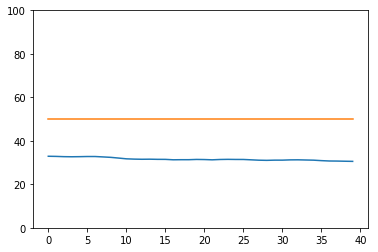

In [165]:
plt.plot(prob.hMap * mopt)
plt.plot(prob.hMap * m0)
plt.ylim(0, 100)

(0.001, 1)

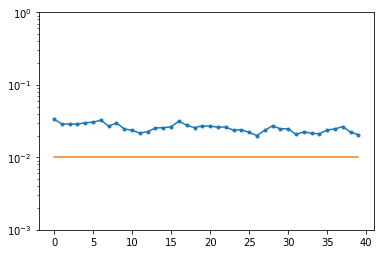

In [166]:
plt.semilogy(prob.sigmaMap * mopt, '.-')
plt.plot(prob.sigmaMap * m0)
plt.ylim(0.001, 1)